In [1]:
import numpy,os,sklearn
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection as sms

import utils

# Image Data

## Suspicious Mammographies (BCDR-D01 & BCDR-D02)

In [ ]:
bcdr1_raw = pd.read_csv('d:/BCDR/BCDR-D01_dataset/bcdr_d01_img.csv')
bcdr1_raw = bcdr1_raw.drop_duplicates(subset=['image_filename'],keep='first',ignore_index=True)
bcdr1_raw= utils.fix_view(bcdr1_raw,'image_type_name')
bcdr1_features_raw = pd.read_csv('D:\BCDR\BCDR-D01_dataset/bcdr_d01_features.csv')
bcdr2_raw = pd.read_csv('d:/BCDR/BCDR-D02_dataset/bcdr_d02_img.csv')
bcdr2_raw = bcdr2_raw.drop_duplicates(subset=['image_filename'],keep='first',ignore_index=True)
bcdr2_raw= utils.fix_view(bcdr2_raw,'image_type_name')
bcdr2_features_raw = pd.read_csv('D:\BCDR\BCDR-D02_dataset/bcdr_d02_features.csv')
l1 = utils.lesion_findings(bcdr1_features_raw)
l2 = utils.lesion_findings(bcdr2_features_raw)

In [ ]:
bcdr1 = bcdr1_raw[['patient_id','study_id','image_filename','image_type_name','density','age']]
bcdr1_features= bcdr1_features_raw[['patient_id','study_id','image_view','s_x_center_mass','s_y_center_mass','density','age']]

bcdr1 = utils.merge_csv(bcdr1_features,bcdr1)
bcdr1['lesion_type'] = l1

In [ ]:
bcdr2 = bcdr2_raw[['patient_id','study_id','image_filename','image_type_name','density','age']]
bcdr2_features= bcdr2_features_raw[['patient_id','study_id','image_view','s_x_center_mass','s_y_center_mass','density','age']]

bcdr2 = utils.merge_csv(bcdr2_features,bcdr2)
bcdr2['lesion_type'] = l2

In [ ]:
lesion_mammographies1 = pd.DataFrame({})
lesion_mammographies1[['patient_id','image_view','image_path','x_center','y_center','density','age','lesion_type']] = bcdr1[['patient_id','image_view','image_filename','s_x_center_mass','s_y_center_mass','density','age','lesion_type']]
new_patients = []
for patient in list(lesion_mammographies1['patient_id']):
    patient_n= '1d'+str(patient)
    new_patients.append(patient_n)
lesion_mammographies1['patient_id'] = new_patients
lesion_mammographies1 = utils.fix_bcdr1_path(lesion_mammographies1,'image_path')

In [ ]:
lesion_mammographies2 = pd.DataFrame({})
lesion_mammographies2[['patient_id','image_view','image_path','x_center','y_center','density','age','lesion_type']] = bcdr2[['patient_id','image_view','image_filename','s_x_center_mass','s_y_center_mass','density','age','lesion_type']]
new_patients = []
for patient in list(lesion_mammographies2['patient_id']):
    patient_n= '2d'+str(patient)
    new_patients.append(patient_n)
lesion_mammographies2['patient_id'] = new_patients
lesion_mammographies2 = utils.fix_bcdr2_path(lesion_mammographies2,'image_path')
lesion_mammographies2 = lesion_mammographies2[:100]

In [ ]:
lesion_mammographies = pd.concat([lesion_mammographies1,lesion_mammographies2],ignore_index=True)
lesion_mammographies = utils.fix_view_back(lesion_mammographies,'image_view')
print('Suspicious Dataset: ',lesion_mammographies.shape)

### Split

In [ ]:
list_suspicious_dfs = numpy.array_split(lesion_mammographies,3)

In [ ]:
for df in list_suspicious_dfs:
    print(df.shape)

## Normal Mammographies (BCDR-DN01 & INbreast)

In [ ]:
bcdrN = pd.read_csv('d:/BCDR/BCDR-DN01_dataset/bcdr_dn01_img.csv')

normal_mammographies1 = pd.DataFrame({})
normal_mammographies1[['patient_id','image_view','image_path','density','age']] = bcdrN[['patient_id','image_type_name','image_filename','density','age']]
normal_mammographies1 = utils.fix_bcdrN_path(normal_mammographies1,'image_path')

In [ ]:
xls_raw = pd.read_excel('D:/INBreast/INbreast.xls')
xls = pd.DataFrame()
xls['image_view'] = [xls_raw['Laterality'][i] + xls_raw['View'][i] for i in xls_raw.index] 
xls[['filename','finding notes']] = xls_raw[['File Name','Findings Notes (in Portuguese)']]

In [ ]:
path_list = os.listdir('D:/INBreast/AllDICOMs/')
r = []
for path in path_list:
    if path[-3:] != 'dcm':
        r.append(path)
for i in r:
    path_list.remove(i)

In [ ]:
patients = []
file_paths = []
image_views = []
for path in path_list:
    l = path.split('_')
    if len(l) > 1:
        patients.append(l[1])
        file_paths.append(path)
        image_views.append(l[3]+l[4])
images_df = pd.DataFrame({'patient_id':patients,'image_view':image_views,'image_path':file_paths})
images_df = utils.fix_inbreast_path(images_df,'image_path')

In [ ]:
images_df[['finding notes']] = xls[['finding notes']]
normal_df = images_df[images_df['finding notes'] == 'normal']
normal_mammographies2 = pd.DataFrame()
normal_mammographies2[['patient_id','image_view','image_path']] = normal_df[['patient_id','image_view','image_path']]

In [ ]:
normal_mammographies = pd.concat([normal_mammographies1,normal_mammographies2],ignore_index=True)
print('Normal Dataset: ',normal_mammographies.shape)

### Split

In [ ]:
list_normal_dfs = numpy.array_split(normal_mammographies,3)

In [ ]:
for df in list_normal_dfs:
    print(df.shape)

## Move Image Data

In [ ]:
downsample = True
n_folds=3
for i in range(n_folds):

    validation_normal_df = list_normal_dfs[i]
    validation_suspicious_df = list_suspicious_dfs[i]

    if i == 0:
        training_normal_df = pd.concat([n for n in list_normal_dfs[i+1:]],ignore_index=True)
        training_suspicious_df = pd.concat([n for n in list_suspicious_dfs[i+1:]],ignore_index=True)
    elif i == 2:
        training_normal_df = pd.concat([n for n in list_normal_dfs[:i]],ignore_index=True)
        training_suspicious_df = pd.concat([n for n in list_suspicious_dfs[:i]],ignore_index=True)
    else:
        training_normal_df = pd.concat([n for n in list_normal_dfs[:i] + list_normal_dfs[i+1:]],ignore_index=True)
        training_suspicious_df = pd.concat([n for n in list_suspicious_dfs[:i] + list_suspicious_dfs[i+1:]],ignore_index=True)

    training_normal_folder = 'cross validation/image_data/split'+str(i+1)+'/downsampled/training_data/normal'
    validation_normal_folder = 'cross validation/image_data/split'+str(i+1)+'/downsampled/validation_data/normal'
    training_sus_folder = 'cross validation/image_data/split'+str(i+1)+'/downsampled/training_data/suspicious'
    validation_sus_folder = 'cross validation/image_data/split'+str(i+1)+'/downsampled/validation_data/suspicious'

    utils.image_mover(training_normal_df,training_normal_folder,downsample)
    utils.image_mover(training_suspicious_df,training_sus_folder,downsample)
    utils.image_mover(validation_normal_df,validation_normal_folder,downsample)
    utils.image_mover(validation_suspicious_df,validation_sus_folder,downsample)


In [ ]:
0/0

## Negatives

In [ ]:
n_folds=2
fold = 0
for i in range(n_folds):
    i=i+1

    training_normal_folder = 'cross validation/image_data/split'+str(i+1)+'/training_data/normal/'
    validation_normal_folder = 'cross validation/image_data/split'+str(i+1)+'/validation_data/normal/'
    training_sus_folder = 'cross validation/image_data/split'+str(i+1)+'/training_data/suspicious/'
    validation_sus_folder = 'cross validation/image_data/split'+str(i+1)+'/validation_data/suspicious/'

    utils.copy_negatives(training_normal_folder)
    #utils.copy_negatives(training_sus_folder)
    #utils.copy_negatives(validation_normal_folder)
    #utils.copy_negatives(validation_sus_folder)

## Patches

In [ ]:
n_folds=3
for i in range(n_folds):

    training_normal_folder = 'cross validation/image_data/split'+str(i+1)+'/raw/training_data/normal/'
    validation_normal_folder = 'cross validation/image_data/split'+str(i+1)+'/raw/validation_data/normal/'
    training_sus_folder = 'cross validation/image_data/split'+str(i+1)+'/raw/training_data/suspicious/'
    validation_sus_folder = 'cross validation/image_data/split'+str(i+1)+'/raw/validation_data/suspicious/'

    utils.save_patches_by_image(training_normal_folder,300,0.2)
    utils.save_patches_by_image(training_sus_folder,300,0.2)
    utils.save_patches_by_image(validation_normal_folder,300,0.2)
    utils.save_patches_by_image(validation_sus_folder,300,0.2)

# Numerical Data

In [ ]:
n_folds=3
fold = 0
for i in range(n_folds):

    training_normal_folder = 'cross validation/image_data/split'+str(i+1)+'/raw/training_data/normal/'
    validation_normal_folder = 'cross validation/image_data/split'+str(i+1)+'/raw/validation_data/normal/'
    training_sus_folder = 'cross validation/image_data/split'+str(i+1)+'/raw/training_data/suspicious/'
    validation_sus_folder = 'cross validation/image_data/split'+str(i+1)+'/raw/validation_data/suspicious/'
    s = 'cross validation/numerical_data/split'+str(i+1)+'/'

    utils.mammary_features(training_normal_folder,s+'features_training_normal.csv')
    print(i)
    utils.mammary_features(training_sus_folder,s+'features_training_suspicious.csv')
    print(i)
    utils.mammary_features(validation_normal_folder,s+'features_validation_normal.csv')
    print(i)
    utils.mammary_features(validation_sus_folder,s+'features_validation_suspicious.csv')



## Age

In [ ]:
dfs = pd.concat([normal_mammographies,lesion_mammographies],ignore_index=True)
a = []

In [ ]:
a = 'cross validation/numerical_data/split3/features_validation_suspicious.csv'
gt = pd.read_csv('cross validation/image_data/split3/csv/validation_data_suspicious.csv')
features_df = pd.read_csv(a)
ages = []
for i in gt.index:
    p = gt.loc[i,'Original']
    age_index = dfs[dfs['image_path'] == p].index
    age = dfs.loc[age_index,'age'].to_list()[0]
    ages.append(age)
features_df['Age'] = ages
features_df.to_csv(a)

## Area Factor

In [ ]:
s = 'cross validation/image_data/split3/raw/'
afs = []

In [ ]:
for i in ['training_data/normal/','training_data/suspicious/','validation_data/normal/','validation_data/suspicious/']:
    image_folder = s + i
    l = os.listdir(image_folder)
    p = [str(n) for n in range(len(l))]
    ps= []
    for i in p:
        a = image_folder+i+'.bmp'
        ps.append(a)

    area_factors = []

    for image_path in ps:
        af = utils.breast_area_factor(image_path)
        area_factors.append(af)

    afs = afs + area_factors

In [ ]:
r = pd.read_csv('cross validation/numerical_data/split3/classification_data_comp.csv')
r['Area Factor'] = afs
r.to_csv('cross validation/numerical_data/split3/classification_data_comp.csv',index=False)

# Split 1

## Load Numerical Data

In [ ]:
features_training_normal = pd.read_csv('cross validation/numerical_data/split1/features_training_normal.csv')
features_training_suspicious = pd.read_csv('cross validation/numerical_data/split1/features_training_suspicious.csv')
features_validation_normal = pd.read_csv('cross validation/numerical_data/split1/features_validation_normal.csv')
features_validation_suspicious = pd.read_csv('cross validation/numerical_data/split1/features_validation_suspicious.csv')

## Evaluate Mammographies

In [ ]:
dataframe = pd.concat([features_training_normal,features_training_suspicious,features_validation_normal,features_validation_suspicious],ignore_index=True)
model = keras.models.load_model('cross validation/models/split1.h5')
a = utils.classify_mammograms(model,dataframe,'cross validation/numerical_data/split1/classification_data_comp.csv')

In [ ]:
dataframe = pd.read_csv('cross validation/numerical_data/split1/classification_data_comp.csv')

In [ ]:
data= utils.generator_crossval(1500,1100,'cross validation/image_data/split1/downsampled')
y_true = data[1].classes
y_pred = list(dataframe['Classifications'])[-166:]

In [ ]:
classes = ['Normal','Suspicious']
c = sklearn.metrics.confusion_matrix(y_true,numpy.round(y_pred),normalize='true')
c = numpy.around(c,decimals =2)

plt.figure(figsize=(5, 5))
plt.imshow(c)

plt.xticks(numpy.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(numpy.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        text = plt.text(j, i, c[i, j],
                       ha="center", va="center", color="w",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.show()

In [ ]:
acc = sklearn.metrics.accuracy_score(y_true,numpy.round(y_pred))
print('Accuracy:',acc)

In [ ]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)
print('AUC:',auc)

In [ ]:
0/0

## Evaluate Patches

In [ ]:
training_normal_folder = 'cross validation/image_data/split1/raw/training_data/normal/'
validation_normal_folder = 'cross validation/image_data/split1/raw/validation_data/normal/'
training_sus_folder = 'cross validation/image_data/split1/raw/training_data/suspicious/'
validation_sus_folder = 'cross validation/image_data/split1/raw/validation_data/suspicious/'

In [ ]:
utils.classify_patches('cross validation/image_data/split1/raw/training_data/normal/')
utils.classify_patches('cross validation/image_data/split1/raw/validation_data/normal/')
utils.classify_patches('cross validation/image_data/split1/raw/training_data/suspicious/')
utils.classify_patches('cross validation/image_data/split1/raw/validation_data/suspicious/')

In [ ]:
utils.add_to_features_csv('cross validation/image_data/split1/raw/training_data/normal/','cross validation/numerical_data/split1/features_training_normal.csv',0.4)
utils.add_to_features_csv('cross validation/image_data/split1/raw/training_data/suspicious/','cross validation/numerical_data/split1/features_training_suspicious.csv',0.4)
utils.add_to_features_csv('cross validation/image_data/split1/raw/validation_data/normal/','cross validation/numerical_data/split1/features_validation_normal.csv',0.4)
utils.add_to_features_csv('cross validation/image_data/split1/raw/validation_data/suspicious/','cross validation/numerical_data/split1/features_validation_suspicious.csv',0.4)

In [ ]:
utils.add_to_final_csv(1,'cross validation/numerical_data/split1/classification_data_comp.csv')

## Metaclassification

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

In [3]:
dataframe = pd.read_csv('cross validation/numerical_data/split1/classification_data_comp.csv')
dataframe = dataframe.sample(n=len(dataframe.index))

In [6]:
X = dataframe.loc[:, dataframe.columns != 'Ground Truth']
X = X.loc[:, X.columns != 'Unnamed: 0']
X = X.loc[:, X.columns != 'Unnamed: 0.1']
X = X.loc[:, X.columns != 'Ratio']
X = X.loc[:, X.columns != 'Ratios']
X = X.loc[:, X.columns != 'Area Factor']
#X = X.loc[:, X.columns != 'I_Kurtosis']
#X = X.loc[:, X.columns != 'I_Mode']
#X = X.loc[:, X.columns != 'I_Std']
#X = X.loc[:, X.columns != 'I_Median']
#X = X.loc[:, X.columns != 'T_Entropy']
#X = X.loc[:, X.columns != 'I_Skewness']
y = dataframe['Ground Truth']

In [7]:
my_imputer = SimpleImputer(strategy='constant',fill_value=56)
imputed_X_train_age = my_imputer.fit_transform(numpy.array(X['Age']).reshape(-1,1))
X['Age'] = imputed_X_train_age
X = X.astype({'Age': 'int32'})

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.35)
X.head(5)

,I_Mean,I_Std,I_Median,I_Mode,T_Entropy,I_Skewness,I_Kurtosis,Age,Classifications
358,130.51237,44.79107,128.0,131,5.03009,0.33240,-0.06570,46,0.203
153,92.77876,23.49349,89.0,81,4.35004,0.78792,2.08622,56,0.152
454,125.83947,35.55868,129.0,131,4.83826,-0.24087,0.30544,55,0.999
451,139.18852,23.07211,144.0,147,4.16906,-1.53822,3.72564,54,0.443
435,125.80311,79.06698,100.0,255,4.90069,0.55050,-1.20942,54,0.963


In [9]:
forest_model = RandomForestClassifier()
pipeline = Pipeline(steps=[('model',forest_model)])
pipeline.fit(X_train,y_train)

Pipeline(steps=[('model', RandomForestClassifier())])

<BarContainer object of 9 artists>

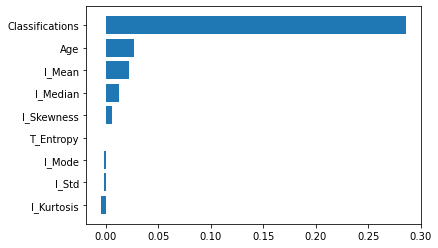

In [10]:
result = permutation_importance(pipeline, X_valid, y_valid, n_repeats=10)
sorted_idx = result.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], result.importances_mean[sorted_idx])

In [11]:
p = {'n_estimators':[50,100,500,1000,1500,2000],'max_depth':[5,6,7,8,9]}
c = GridSearchCV(forest_model,p,scoring='roc_auc')
c.fit(X,y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 6, 7, 8, 9],
                         'n_estimators': [50, 100, 500, 1000, 1500, 2000]},
             scoring='roc_auc')

In [12]:
c.best_estimator_

RandomForestClassifier(max_depth=8, n_estimators=2000)

In [13]:
c.best_score_

0.953376350540216

In [19]:
forest_model = RandomForestClassifier(max_depth=8, n_estimators=2000, random_state=99)
pipeline = Pipeline(steps=[('model',forest_model)])
scores = cross_val_score(pipeline, X, y,cv=5,scoring='accuracy')
print('AUC: \n',scores)

AUC: 
 [0.83       0.82       0.9        0.88888889 0.88888889]


In [12]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict_proba(X_valid)

In [13]:
ypred = []
for i in y_pred:
    if i[0] > 0.44:
        ypred.append(0)
    else:
        ypred.append(1)

Sensitivity: 0.83
Specificity: 0.93


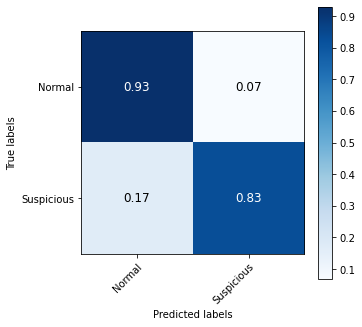

In [14]:
classes = ['Normal','Suspicious']
c = sklearn.metrics.confusion_matrix(y_valid,ypred,normalize='true')
c = numpy.around(c,decimals =2)

plt.figure(figsize=(5, 5))
plt.imshow(c,cmap='Blues')

plt.xticks(numpy.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(numpy.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        if c[i,j]<0.5:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="black",fontsize='large')
        else:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="w",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.show()

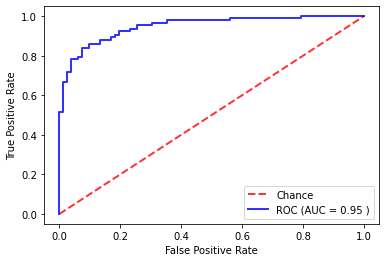

In [15]:
ypred=[]
for i in y_pred:
    ypred.append(i[1])
auc = sklearn.metrics.roc_auc_score(y_valid,ypred)
fpr,tpr,t= sklearn.metrics.roc_curve(y_valid,ypred)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.plot(fpr,tpr, color='b',
        label=r'ROC (AUC = %0.2f )' % (auc),
        lw=2, alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.legend(loc="lower right")
#print('AUC:',auc)

In [19]:
acc = []
for n in range(100):
    forest_model = RandomForestClassifier(max_depth=8,n_estimators=2000,random_state=n)
    pipeline = Pipeline(steps=[('model',forest_model)])
    scores = cross_val_score(pipeline, X, y,cv=5,scoring='roc_auc')
    acc.append(scores)

In [20]:
accs = []
for i in acc:
    accs.append(sum(i)/len(i))

In [21]:
a = pd.DataFrame({'With Patches':accs})
a.describe()

,With Patches
count,100.000000
mean,0.952211
std,0.000635
min,0.951035
25%,0.951759
50%,0.952162
75%,0.952647
max,0.953778


# Split 2

## Load Numerical Data

In [8]:
features_training_normal = pd.read_csv('cross validation/numerical_data/split2/features_training_normal.csv')
features_training_suspicious = pd.read_csv('cross validation/numerical_data/split2/features_training_suspicious.csv')
features_validation_normal = pd.read_csv('cross validation/numerical_data/split2/features_validation_normal.csv')
features_validation_suspicious = pd.read_csv('cross validation/numerical_data/split2/features_validation_suspicious.csv')

## Evaluate Mammographies

In [7]:
dataframe = pd.concat([features_training_normal,features_training_suspicious,features_validation_normal,features_validation_suspicious],ignore_index=True)
model = keras.models.load_model('cross validation/models/split2.h5')
a = utils.classify_mammograms(model,dataframe,'cross validation/numerical_data/split2/classification_data_comp.csv')

NameError: name 'features_training_normal' is not defined

In [9]:
dataframe = pd.read_csv('cross validation/numerical_data/split2/classification_data_comp.csv')

In [10]:
data= utils.generator_crossval(1500,1100,'cross validation/image_data/split2/downsampled')
y_true = data[1].classes
y_pred = list(dataframe['Classifications'])[-166:]

Found 332 images belonging to 2 classes.
Found 166 images belonging to 2 classes.


Sensitivity: 0.21
Specificity: 0.99


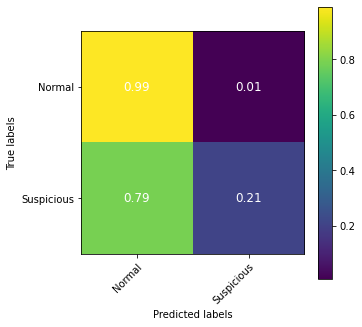

In [11]:
classes = ['Normal','Suspicious']
c = sklearn.metrics.confusion_matrix(y_true,numpy.round(y_pred),normalize='true')
c = numpy.around(c,decimals =2)

plt.figure(figsize=(5, 5))
plt.imshow(c)

plt.xticks(numpy.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(numpy.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        text = plt.text(j, i, c[i, j],
                       ha="center", va="center", color="w",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.show()

In [12]:
c

array([[0.99, 0.01],
       [0.79, 0.21]])

Sensitivity: 0.75
Specificity: 0.7435897435897436


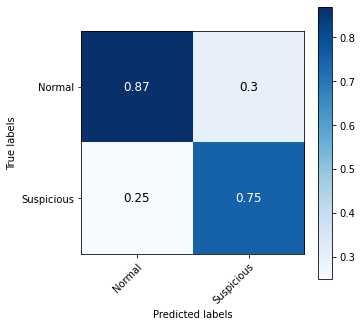

In [26]:
classes = ['Normal','Suspicious']
c = numpy.array([[0.87,0.30],[0.25,0.75]])

plt.figure(figsize=(5, 5))
plt.imshow(c,cmap='Blues')

plt.xticks(numpy.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(numpy.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        if c[i,j] < 0.5:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="black",fontsize='large')
        else:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="white",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.show()

In [15]:
c

array([[870,  30],
       [ 25,  75]])

In [5]:
acc = sklearn.metrics.accuracy_score(y_true,numpy.round(y_pred))
print('Accuracy:',acc)

Accuracy: 0.608433734939759


AUC: 0.64800290486565


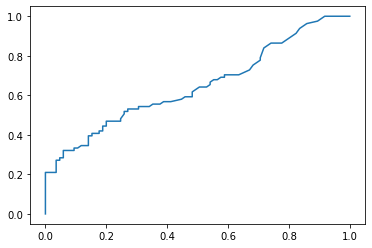

In [6]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)
print('AUC:',auc)

In [ ]:
0/0

## Evaluate Patches

In [ ]:
training_normal_folder = 'cross validation/image_data/split2/raw/training_data/normal/'
validation_normal_folder = 'cross validation/image_data/split2/raw/validation_data/normal/'
training_sus_folder = 'cross validation/image_data/split2/raw/training_data/suspicious/'
validation_sus_folder = 'cross validation/image_data/split2/raw/validation_data/suspicious/'

In [ ]:
utils.classify_patches('cross validation/image_data/split2/raw/training_data/normal/')
utils.classify_patches('cross validation/image_data/split2/raw/validation_data/normal/')
utils.classify_patches('cross validation/image_data/split2/raw/training_data/suspicious/')
utils.classify_patches('cross validation/image_data/split2/raw/validation_data/suspicious/')

In [ ]:
utils.add_to_features_csv('cross validation/image_data/split2/raw/training_data/normal/','cross validation/numerical_data/split2/features_training_normal.csv',0.4)
utils.add_to_features_csv('cross validation/image_data/split2/raw/training_data/suspicious/','cross validation/numerical_data/split2/features_training_suspicious.csv',0.4)
utils.add_to_features_csv('cross validation/image_data/split2/raw/validation_data/normal/','cross validation/numerical_data/split2/features_validation_normal.csv',0.4)
utils.add_to_features_csv('cross validation/image_data/split2/raw/validation_data/suspicious/','cross validation/numerical_data/split2/features_validation_suspicious.csv',0.4)

In [ ]:
utils.add_to_final_csv(2,'cross validation/numerical_data/split2/classification_data_comp.csv')

## Metaclassification

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

In [22]:
dataframe = pd.read_csv('cross validation/numerical_data/split2/classification_data_comp.csv')
dataframe = dataframe.sample(n=len(dataframe.index))

In [21]:
X = dataframe.loc[:, dataframe.columns != 'Ground Truth']
X = X.loc[:, X.columns != 'Unnamed: 0']
X = X.loc[:, X.columns != 'Unnamed: 0.1']
X = X.loc[:, X.columns != 'Ratio']
X = X.loc[:, X.columns != 'Ratios']
X = X.loc[:, X.columns != 'Area Factor']
#X = X.loc[:, X.columns != 'I_Kurtosis']
#X = X.loc[:, X.columns != 'I_Mode']
#X = X.loc[:, X.columns != 'I_Std']
#X = X.loc[:, X.columns != 'I_Median']
#X = X.loc[:, X.columns != 'T_Entropy']
#X = X.loc[:, X.columns != 'I_Skewness']
y = dataframe['Ground Truth']

In [22]:
my_imputer = SimpleImputer(strategy='constant',fill_value=56)
imputed_X_train_age = my_imputer.fit_transform(numpy.array(X['Age']).reshape(-1,1))
X['Age'] = imputed_X_train_age
X = X.astype({'Age': 'int32'})

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.35)
X.head(5)

,I_Mean,I_Std,I_Median,I_Mode,T_Entropy,I_Skewness,I_Kurtosis,Age,Classifications
358,130.51237,44.79107,128.0,131,5.03009,0.33240,-0.06570,46,0.203
153,92.77876,23.49349,89.0,81,4.35004,0.78792,2.08622,56,0.152
454,125.83947,35.55868,129.0,131,4.83826,-0.24087,0.30544,55,0.999
451,139.18852,23.07211,144.0,147,4.16906,-1.53822,3.72564,54,0.443
435,125.80311,79.06698,100.0,255,4.90069,0.55050,-1.20942,54,0.963


In [28]:
forest_model = RandomForestClassifier()
p = {'n_estimators':[50,100,500,1000,1500,2000],'max_depth':[5,6,7,8,9]}
c = GridSearchCV(forest_model,p,scoring='roc_auc')
c.fit(X,y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 6, 7, 8, 9],
                         'n_estimators': [50, 100, 500, 1000, 1500, 2000]},
             scoring='roc_auc')

In [29]:
c.best_estimator_

RandomForestClassifier(max_depth=9, n_estimators=500)

In [30]:
c.best_score_

0.9221788715486194

In [24]:
forest_model = RandomForestClassifier(max_depth=9, n_estimators=500)
pipeline = Pipeline(steps=[('model',forest_model)])
scores = cross_val_score(pipeline, X, y,cv=5,scoring='accuracy')
print('AUC: \n',scores)

AUC: 
 [0.84       0.8        0.88       0.88888889 0.88888889]


In [25]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict_proba(X_valid)

In [26]:
ypred = []
for i in y_pred:
    if i[0] > 0.44:
        ypred.append(0)
    else:
        ypred.append(1)

Sensitivity: 0.85
Specificity: 0.94


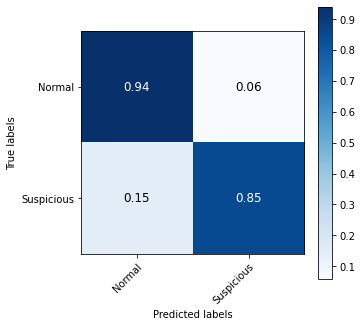

In [27]:
classes = ['Normal','Suspicious']
c = sklearn.metrics.confusion_matrix(y_valid,ypred,normalize='true')
c = numpy.around(c,decimals =2)

plt.figure(figsize=(5, 5))
plt.imshow(c,cmap='Blues')

plt.xticks(numpy.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(numpy.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        if c[i,j]<0.5:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="black",fontsize='large')
        else:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="w",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.show()

AUC: 0.9563740856844306


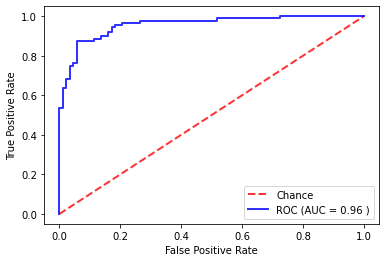

In [28]:
ypred=[]
for i in y_pred:
    ypred.append(i[1])
auc = sklearn.metrics.roc_auc_score(y_valid,ypred)
fpr,tpr,t= sklearn.metrics.roc_curve(y_valid,ypred)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.plot(fpr,tpr, color='b',
        label=r'ROC (AUC = %0.2f )' % (auc),
        lw=2, alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.legend(loc="lower right")
print('AUC:',auc)

In [36]:
acc = []
for n in range(100):
    forest_model = RandomForestClassifier(max_depth=9,n_estimators=500,random_state=n)
    pipeline = Pipeline(steps=[('model',forest_model)])
    scores = cross_val_score(pipeline, X, y,cv=5,scoring='roc_auc')
    acc.append(scores)

In [37]:
accs = []
for i in acc:
    accs.append(sum(i)/len(i))

In [38]:
a = pd.DataFrame({'With Patches':accs})
a.describe()

,With Patches
count,100.000000
mean,0.919181
std,0.001239
min,0.916612
25%,0.918296
50%,0.919249
75%,0.919937
max,0.922667


# Split 3

## Load Numerical Data

In [ ]:
features_training_normal = pd.read_csv('cross validation/numerical_data/split3/features_training_normal.csv')
features_training_suspicious = pd.read_csv('cross validation/numerical_data/split3/features_training_suspicious.csv')
features_validation_normal = pd.read_csv('cross validation/numerical_data/split3/features_validation_normal.csv')
features_validation_suspicious = pd.read_csv('cross validation/numerical_data/split3/features_validation_suspicious.csv')

## Evaluate Mammographies

In [ ]:
dataframe = pd.concat([features_training_normal,features_training_suspicious,features_validation_normal,features_validation_suspicious],ignore_index=True)
model = keras.models.load_model('cross validation/models/split3.h5')
a = utils.classify_mammograms(model,dataframe,'cross validation/numerical_data/split3/classification_data_comp.csv')

In [7]:
dataframe = pd.read_csv('cross validation/numerical_data/split3/classification_data_comp.csv')

In [8]:
data= utils.generator_crossval(1500,1100,'cross validation/image_data/split3/downsampled')
y_true = data[1].classes
y_pred = list(dataframe['Classifications'])[-166:]

Found 332 images belonging to 2 classes.
Found 166 images belonging to 2 classes.


Sensitivity: 0.44
Specificity: 0.98


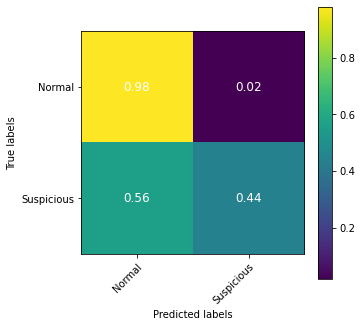

In [9]:
classes = ['Normal','Suspicious']
c = sklearn.metrics.confusion_matrix(y_true,numpy.round(y_pred),normalize='true')
c = numpy.around(c,decimals =2)

plt.figure(figsize=(5, 5))
plt.imshow(c)

plt.xticks(numpy.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(numpy.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        text = plt.text(j, i, c[i, j],
                       ha="center", va="center", color="w",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.show()

In [10]:
acc = sklearn.metrics.accuracy_score(y_true,numpy.round(y_pred))
print('Accuracy:',acc)

Accuracy: 0.7168674698795181


AUC: 0.8120551924473492


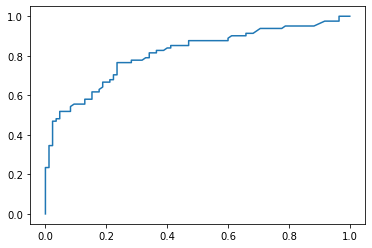

In [11]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)
print('AUC:',auc)

In [ ]:
0/0

## Evaluate Patches

In [ ]:
utils.classify_patches('cross validation/image_data/split3/raw/training_data/normal/')
utils.classify_patches('cross validation/image_data/split3/raw/validation_data/normal/')
utils.classify_patches('cross validation/image_data/split3/raw/training_data/suspicious/')
utils.classify_patches('cross validation/image_data/split3/raw/validation_data/suspicious/')

In [ ]:
utils.add_to_features_csv('cross validation/image_data/split3/raw/training_data/normal/','cross validation/numerical_data/split3/features_training_normal.csv',0.4)
utils.add_to_features_csv('cross validation/image_data/split3/raw/training_data/suspicious/','cross validation/numerical_data/split3/features_training_suspicious.csv',0.4)
utils.add_to_features_csv('cross validation/image_data/split3/raw/validation_data/normal/','cross validation/numerical_data/split3/features_validation_normal.csv',0.4)
utils.add_to_features_csv('cross validation/image_data/split3/raw/validation_data/suspicious/','cross validation/numerical_data/split3/features_validation_suspicious.csv',0.4)

In [ ]:
utils.add_to_final_csv(3,'cross validation/numerical_data/split3/classification_data_comp.csv')

## Metaclassification

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

In [30]:
dataframe = pd.read_csv('cross validation/numerical_data/split3/classification_data_comp.csv')
dataframe = dataframe.sample(n=len(dataframe.index))

In [31]:
X = dataframe.loc[:, dataframe.columns != 'Ground Truth']
X = X.loc[:, X.columns != 'Unnamed: 0']
X = X.loc[:, X.columns != 'Unnamed: 0.1']
X = X.loc[:, X.columns != 'Ratio']
X = X.loc[:, X.columns != 'Ratios']
X = X.loc[:, X.columns != 'Area Factor']
#X = X.loc[:, X.columns != 'I_Kurtosis']
#X = X.loc[:, X.columns != 'I_Mode']
#X = X.loc[:, X.columns != 'I_Std']
#X = X.loc[:, X.columns != 'I_Median']
#X = X.loc[:, X.columns != 'T_Entropy']
#X = X.loc[:, X.columns != 'I_Skewness']
y = dataframe['Ground Truth']

In [32]:
my_imputer = SimpleImputer(strategy='constant',fill_value=56)
imputed_X_train_age = my_imputer.fit_transform(numpy.array(X['Age']).reshape(-1,1))
X['Age'] = imputed_X_train_age
X = X.astype({'Age': 'int32'})

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.35)
X.head(5)

,I_Mean,I_Std,I_Median,I_Mode,T_Entropy,I_Skewness,I_Kurtosis,Age,Classifications
257,109.77820,37.61436,109.0,105,4.83214,0.35231,0.44119,48,0.425
398,115.55641,27.29154,115.0,113,4.56577,0.16247,0.09815,56,0.016
126,131.80929,42.71654,133.0,131,4.97953,0.01336,0.04663,42,0.144
420,102.92605,44.92447,97.0,97,4.92456,0.54679,-0.11716,60,0.192
159,142.54964,43.01560,143.0,131,5.02698,-0.10347,-0.25517,40,0.020


In [34]:
forest_model = RandomForestClassifier()
p = {'n_estimators':[50,100,500,1000,1500,2000],'max_depth':[5,6,7,8,9]}
c = GridSearchCV(forest_model,p,scoring='roc_auc')
c.fit(X,y)

KeyboardInterrupt: 

In [44]:
c.best_estimator_

RandomForestClassifier(max_depth=9, n_estimators=500)

In [45]:
c.best_score_

0.9158663465386153

In [35]:
forest_model = RandomForestClassifier(max_depth=9, n_estimators=500, random_state=99)
pipeline = Pipeline(steps=[('model',forest_model)])
scores = cross_val_score(pipeline, X, y,cv=5,scoring='accuracy')
print('AUC: \n',scores)

AUC: 
 [0.7        0.81       0.76       0.82828283 0.76767677]


In [36]:
result = permutation_importance(forest_model, X_valid, y_valid, n_repeats=10)
sorted_idx = result.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], result.importances_mean[sorted_idx])

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [37]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict_proba(X_valid)

In [38]:
ypred = []
for i in y_pred:
    if i[0] > 0.44:
        ypred.append(0)
    else:
        ypred.append(1)

Sensitivity: 0.69
Specificity: 0.91


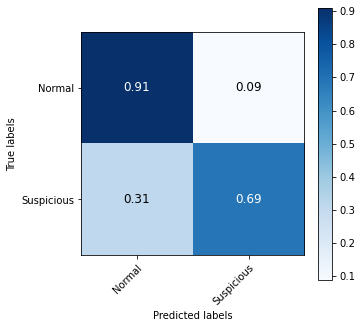

In [39]:
classes = ['Normal','Suspicious']
c = sklearn.metrics.confusion_matrix(y_valid,ypred,normalize='true')
c = numpy.around(c,decimals =2)

plt.figure(figsize=(5, 5))
plt.imshow(c,cmap='Blues')

plt.xticks(numpy.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(numpy.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        if c[i,j]<0.5:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="black",fontsize='large')
        else:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="w",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.show()

AUC: 0.9151633986928105


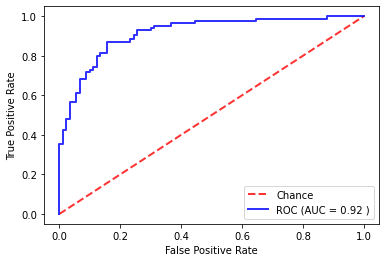

In [40]:
ypred=[]
for i in y_pred:
    ypred.append(i[1])
auc = sklearn.metrics.roc_auc_score(y_valid,ypred)
fpr,tpr,t= sklearn.metrics.roc_curve(y_valid,ypred)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.plot(fpr,tpr, color='b',
        label=r'ROC (AUC = %0.2f )' % (auc),
        lw=2, alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.legend(loc="lower right")
print('AUC:',auc)

In [54]:
acc = []
for n in range(100):
    forest_model = RandomForestClassifier(max_depth=9,n_estimators=500,random_state=n)
    pipeline = Pipeline(steps=[('model',forest_model)])
    scores = cross_val_score(pipeline, X, y,cv=5,scoring='roc_auc')
    acc.append(scores)

In [55]:
accs = []
for i in acc:
    accs.append(sum(i)/len(i))

In [56]:
a = pd.DataFrame({'With Patches':accs})
a.describe()

,With Patches
count,100.000000
mean,0.914719
std,0.001403
min,0.910051
25%,0.914139
50%,0.914823
75%,0.915602
max,0.917957


# Cross Validation Results

In [8]:
auc = format((0.951+0.919+0.915)/3,'.3f')
print('AUC:',auc)

AUC: 0.93


In [13]:
spec = format((0.86+0.91+0.94)/3,'.3f')
print('Specificity:',spec)

Specificity: 0.903


In [14]:
sens = format((0.85+0.8+0.75)/3,'.3f')
print('Sensitivity:',sens)

Sensitivity: 0.800
